In [ ]:
! pip -q install equinox

In [ ]:
! pip -q install --upgrade findiff

In [ ]:
import numpy as np
import sympy as sp
import jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
import itertools
import time
import optax
import findiff

from jax.ops import segment_max
from jax.lax import scan, cond
from jax import random, jit, vmap, grad
from scipy.sparse import coo_matrix, diags, kron
from scipy.sparse.linalg import spsolve
from scipy.interpolate import griddata
from jax.nn import gelu
from scipy.special import roots_legendre

%config InlineBackend.figure_format='retina'

I am going to consider the following equation

\begin{equation}
    \begin{split}
    -&\text{div}\,\text{grad}\,u(x, y) + \left(b(x, y)\right)^2 = f(x, y),\\
    &\left.u(x, y)\right|_{(x, y) \in \partial \Gamma} = 0,
    \end{split}
\end{equation}

and use finite-difference for the discretization.

# Square domain

In [ ]:
x, y = sp.Symbol("x"), sp.Symbol("y")

exact = x*(1-x)*y*(1-y)*sp.exp(sp.cos(2*sp.pi*y)*x)
b2 = 1 + x*y + 3*x
f = -(exact.diff(x)).diff(x)-(exact.diff(y)).diff(y) + exact*b2

exact = sp.lambdify([x, y], exact, modules="jax")
f = sp.lambdify([x, y], f, modules="jax")
b2 = sp.lambdify([x, y], b2, modules="jax")

In [ ]:
ns = [10, 50, 100]
E = []

for n in ns:
    x = jnp.linspace(0, 1, n+2)[1:-1]
    h = (x[1] - x[0]).item()
    coords = jnp.stack(jnp.meshgrid(x, x, indexing='ij'), 0).reshape(2, -1)

    A = diags([b2(coords[0], coords[1]),], offsets=[0, ])
    Delta = diags([2*jnp.ones((n,)), -jnp.ones((n-1,)), -jnp.ones((n-1,))], offsets=[0, -1, +1]) / h**2
    I = diags([jnp.ones((n,))], offsets=[0,])
    A = A + kron(I, Delta) + kron(Delta, I)

    b = f(coords[0], coords[1])
    sol = spsolve(A, b)
    sol_exact = exact(coords[0], coords[1])
    error = jnp.linalg.norm(sol - sol_exact) / jnp.linalg.norm(sol_exact)
    E.append(error)

E = jnp.array(E)

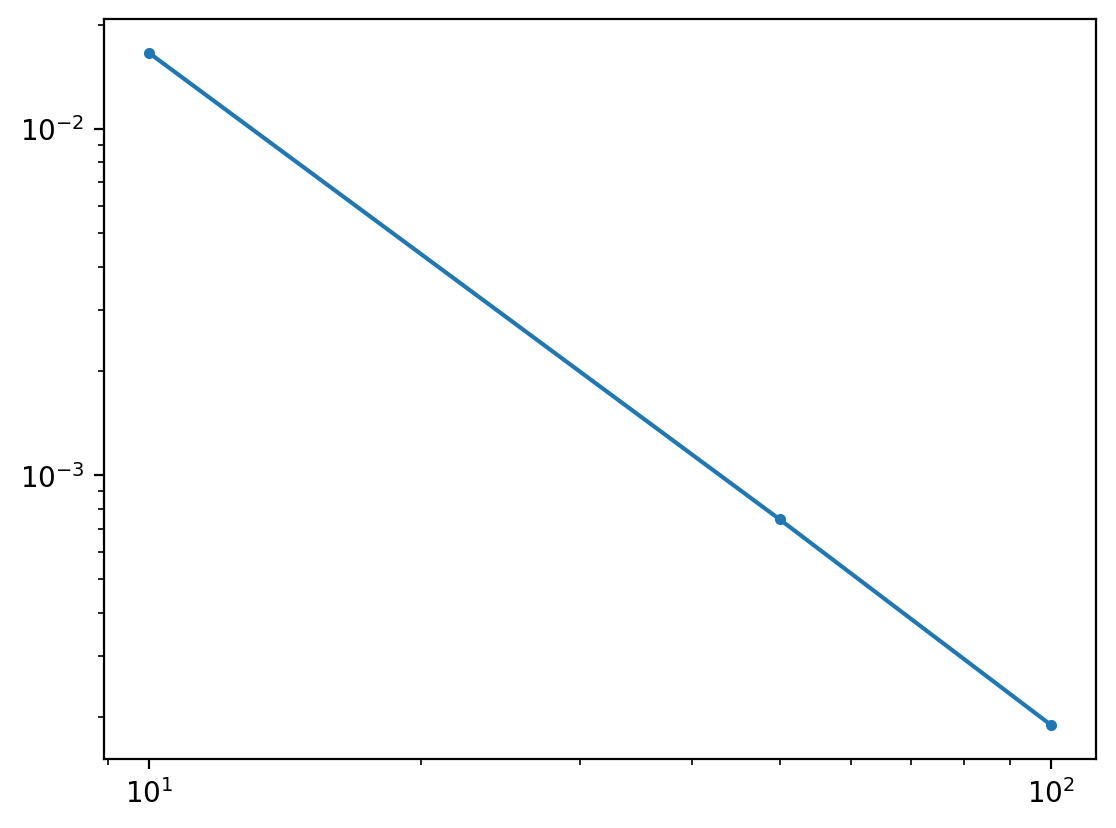

In [ ]:
plt.yscale("log")
plt.xscale("log")
plt.plot(ns, E, ".-");

# L-shaped domain

In [ ]:
b2 = lambda coords: jnp.zeros_like(coords[0])
f = lambda coords: jnp.ones_like(coords[0])

n = 50
N = 2*n + 1
x = jnp.linspace(0, 1, N+2)[1:-1]
h = (x[1] - x[0]).item()
coords = jnp.stack(jnp.meshgrid(x, x, indexing='ij'), 0).reshape(2, -1)
ind = jnp.arange(coords.shape[1])

A = diags([b2(coords),], offsets=[0, ])
Delta = diags([2*jnp.ones((N,)), -jnp.ones((N-1,)), -jnp.ones((N-1,))], offsets=[0, -1, +1]) / h**2
I = diags([jnp.ones((N,))], offsets=[0,])
A = A + kron(I, Delta) + kron(Delta, I)
b = f(coords)

mask = jnp.logical_not((coords[0] >= 0.5) * (coords[1] >= 0.5))
keep_indices = ind[mask]

A = A[keep_indices, :].tocsc()[:, keep_indices]
b = b[keep_indices]
sol = spsolve(A, b)
sol_extended = jnp.zeros_like(coords[0])
sol_extended = sol_extended.at[keep_indices].set(sol)

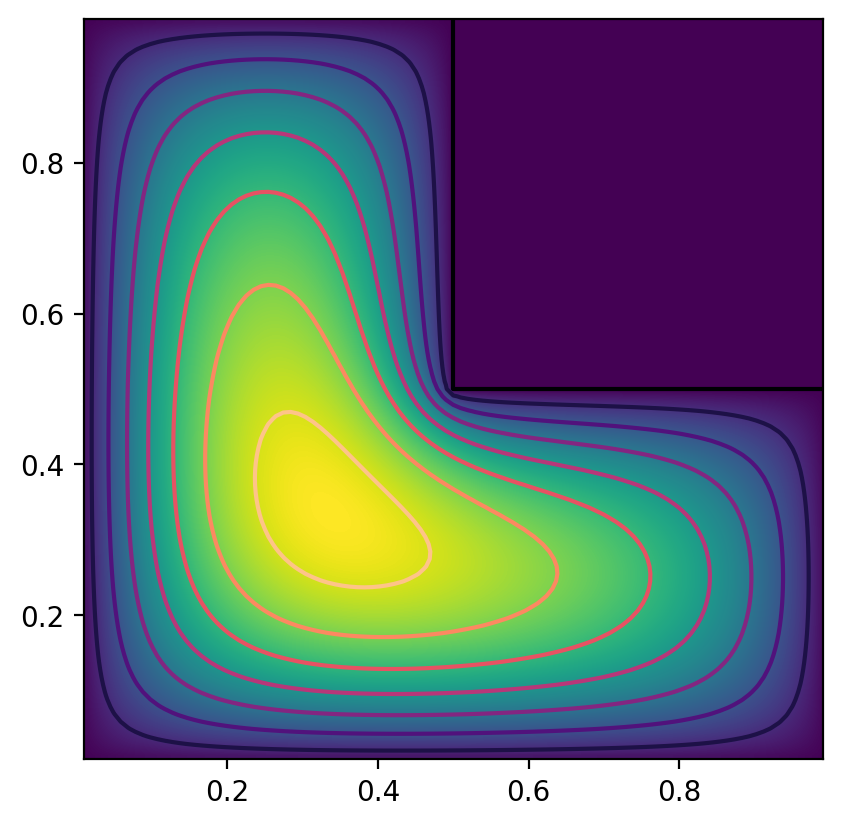

In [ ]:
plt.imshow(sol_extended.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], x[0], x[-1]], interpolation='bilinear', aspect="equal")
plt.contour(coords[0].reshape(N, N), coords[1].reshape(N, N), sol_extended.reshape(N, N), cmap='magma', levels=8);

In [ ]:
b2 = lambda coords: jnp.cos(jnp.pi*coords[0] + 3*jnp.pi*coords[1])**2
f = lambda coords: jnp.exp(jnp.sin(4*jnp.pi*coords[1]))*coords[0]

for n in [50, 100, 150]:
    N = 2*n + 1
    x = jnp.linspace(0, 1, N+2)[1:-1]
    h = (x[1] - x[0]).item()
    coords = jnp.stack(jnp.meshgrid(x, x, indexing='ij'), 0).reshape(2, -1)
    ind = jnp.arange(coords.shape[1])

    A = diags([b2(coords),], offsets=[0, ])
    Delta = diags([2*jnp.ones((N,)), -jnp.ones((N-1,)), -jnp.ones((N-1,))], offsets=[0, -1, +1]) / h**2
    I = diags([jnp.ones((N,))], offsets=[0,])
    A = A + kron(I, Delta) + kron(Delta, I)
    b = f(coords)

    mask = jnp.logical_not((coords[0] >= 0.5) * (coords[1] >= 0.5))
    keep_indices = ind[mask]

    A = A[keep_indices, :].tocsc()[:, keep_indices]
    b = b[keep_indices]
    sol = spsolve(A, b)
    print(n, jnp.max(jnp.abs(sol)))

50 0.02426396
100 0.024273057
150 0.02427507


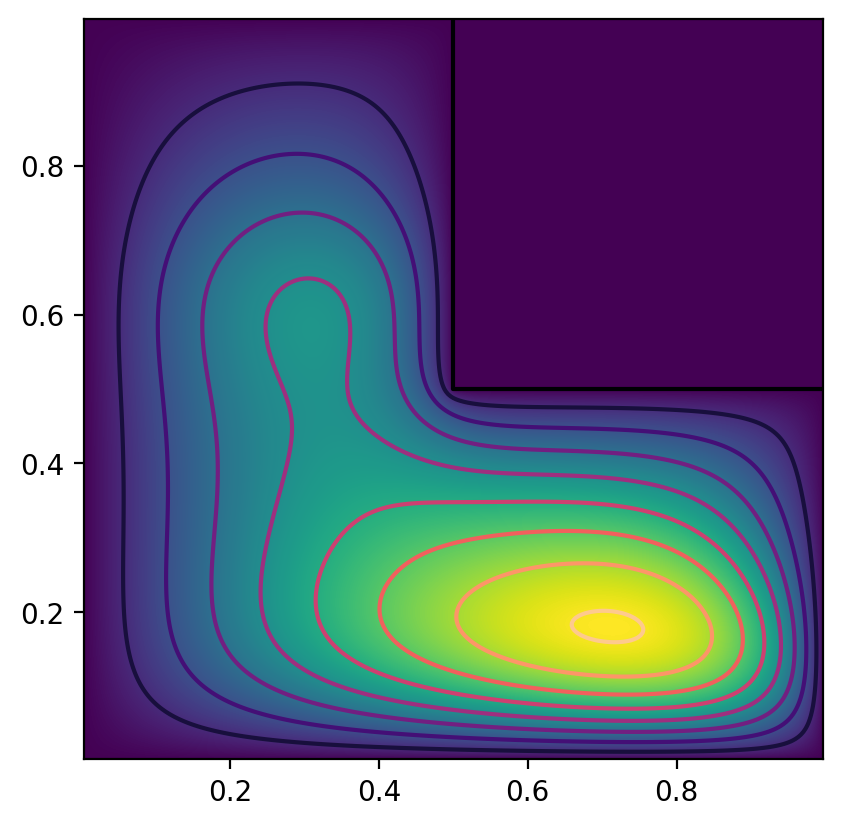

In [ ]:
sol_extended = jnp.zeros_like(coords[0])
sol_extended = sol_extended.at[keep_indices].set(sol)
plt.imshow(sol_extended.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], x[0], x[-1]], interpolation='bilinear', aspect="equal")
plt.contour(coords[0].reshape(N, N), coords[1].reshape(N, N), sol_extended.reshape(N, N), cmap='magma', levels=8);

In [ ]:
def get_solution_data(n, b2, f):
    N = 2*n + 1
    x = y = jnp.linspace(0, 1, N+2)[1:-1]
    h = (x[1] - x[0]).item()
    coords = jnp.stack(jnp.meshgrid(x, x, indexing='ij'), 0).reshape(2, -1)
    ind = jnp.arange(coords.shape[1])

    b2_vals = b2(coords)
    A = diags([b2_vals,], offsets=[0, ])
    Delta = diags([2*jnp.ones((N,)), -jnp.ones((N-1,)), -jnp.ones((N-1,))], offsets=[0, -1, +1]) / h**2
    I = diags([jnp.ones((N,))], offsets=[0,])
    A = A + kron(I, Delta) + kron(Delta, I)
    b = f(coords)

    mask = jnp.logical_not((coords[0] >= 0.5) * (coords[1] >= 0.5))
    keep_indices = ind[mask]

    A = A[keep_indices, :].tocsc()[:, keep_indices]
    b = b[keep_indices]
    sol = spsolve(A, b)
    rhs = jnp.array(b)

    left = jnp.stack([np.zeros_like(y), y], 1)
    right_1 = jnp.stack([np.ones_like(y[:n+1]), y[:n+1]], 1)
    right_2 = jnp.stack([0.5*np.ones_like(y[n:]), y[n:]], 1)

    bottom = np.stack([x, np.zeros_like(y)], 1)
    top_1 = jnp.stack([x[:n+1], np.ones_like(x[:n+1])], 1)
    top_2 = jnp.stack([x[n:], 0.5*np.ones_like(x[n:])], 1)

    corners = jnp.array([
        [0, 0],
        [1.0, 0.0],
        [0.0, 1.0]
    ])

    boundary_points = np.concatenate([left, right_1, right_2, bottom, top_1, top_2, corners], 0)

    return b2_vals[keep_indices], rhs, sol, coords.T, coords[:, keep_indices].T,  boundary_points, keep_indices

# Eigenvalues for $L$-shaped domain

Friedrichs's constant is $1\big/ \sqrt{\min \lambda}$.


According to https://www.sciencedirect.com/science/article/pii/S0377042709006189 the minimal eigenvalue is about $ 9.6397238$ for domain $[-1, 1]^2$ with a cut. In our case domain is twice as small, so eigenvalues are four times large.

In [ ]:
1 / np.sqrt(9.6397238*4)

0.16104146365263858

In [ ]:
1 / (2*np.pi)

0.15915494309189535

Well, this is not that different from what we have using crude estimate.

# Mask for PiNN

In [ ]:
x, a, b, c, d, e = sp.symbols("x, a, b, c, d, e")
s = [a, b, c, d, e]
f = sum([r*x**n for n, r in enumerate(s)])

print(f.subs({x: 0}))
print(f.subs({x: 0.5}))
for i in range(1, 5):
    print(f.diff(x, i).subs({x: 0.5}))

a
a + 0.5*b + 0.25*c + 0.125*d + 0.0625*e
b + 1.0*c + 0.75*d + 0.5*e
2*c + 3.0*d + 3.0*e
6*d + 12.0*e
24*e


In [ ]:
A = jnp.array([
    [1, 0, 0, 0],
    [1, 0.5, 0.25, 0.125],
    [0, 1, 1, 0.75],
    [0, 0, 2, 3],
])

b = jnp.array([2, 1, 0, 0])

jnp.linalg.solve(A, b)

Array([ 2., -6., 12., -8.], dtype=float32)

In [ ]:
A = jnp.array([
    [1, 0, 0],
    [1, 0.5, 0.25],
    [0, 1, 1],
])

b = jnp.array([2, 1, 0])

jnp.linalg.solve(A, b)

Array([ 2., -4.,  4.], dtype=float32)

In [ ]:
A = jnp.array([
    [1, 0, ],
    [1, 0.5,],
])

b = jnp.array([2, 1,])

jnp.linalg.solve(A, b)

Array([ 2., -2.], dtype=float32)

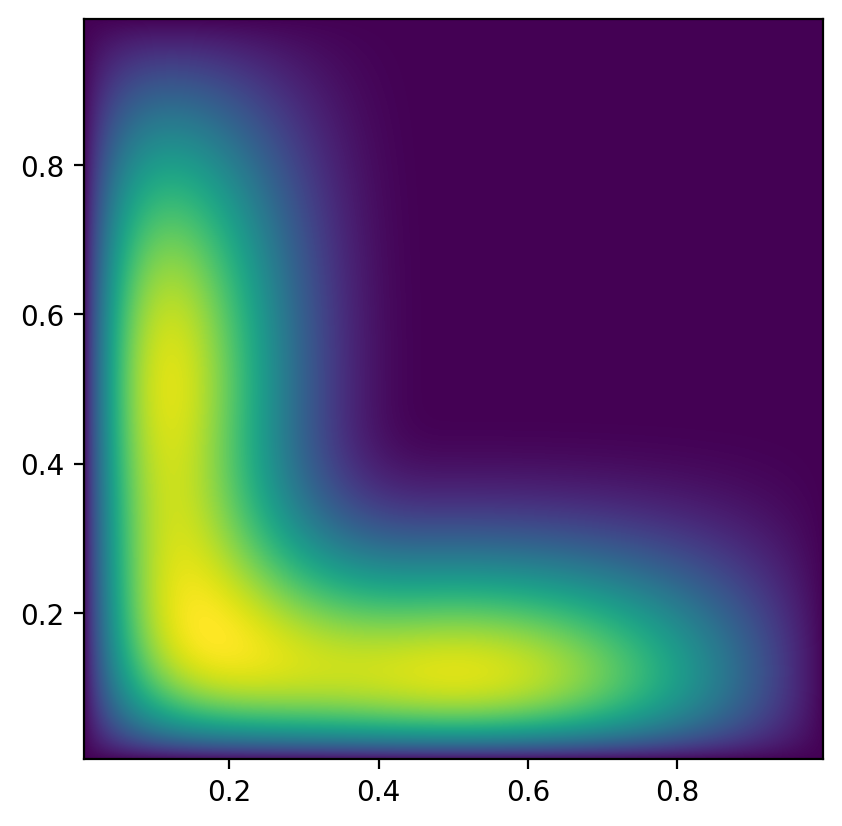

In [ ]:
n = 100
N = M = 2*n + 1
x = jnp.linspace(0, 1, N+2)[1:-1]
y = jnp.linspace(0, 1, M+2)[1:-1]
X, Y = jnp.meshgrid(x, y, indexing='ij')

g = ((X >= 0.5)  + (X < 0.5)*(2 - 6*X + 12*X**2 - 8*X**3)) * ((Y >= 0.5)  + (Y < 0.5)*(2 - 6*Y + 12*Y**2 - 8*Y**3)) - 1
g = g * jnp.sin(jnp.pi*X) * jnp.sin(jnp.pi*Y)
plt.imshow(g.reshape(N, M).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal");

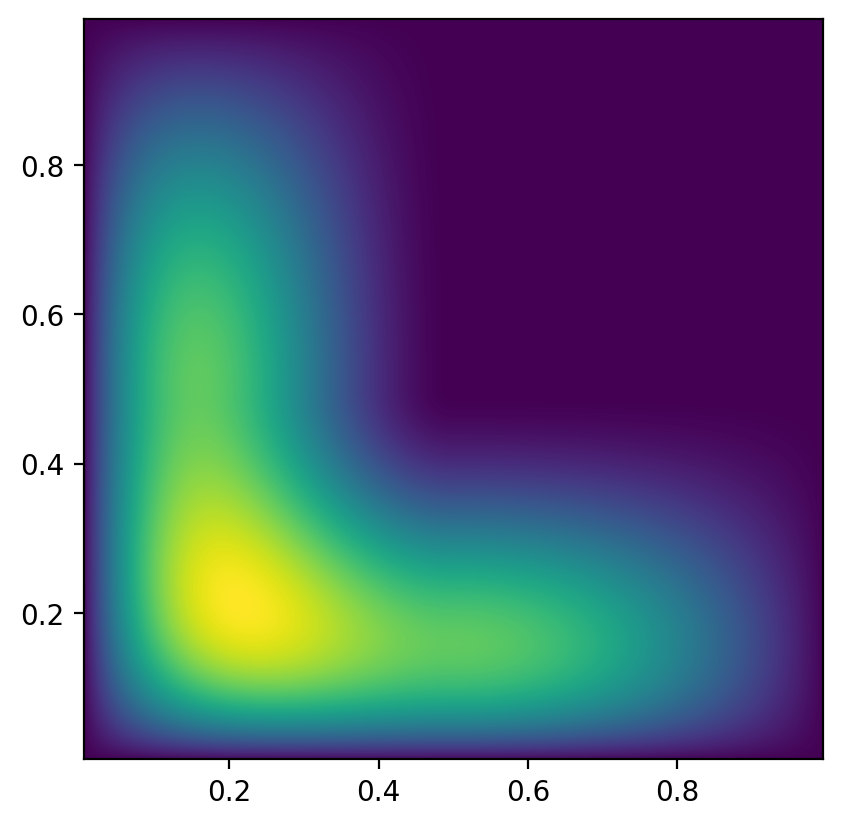

In [ ]:
n = 100
N = M = 2*n + 1
x = jnp.linspace(0, 1, N+2)[1:-1]
y = jnp.linspace(0, 1, M+2)[1:-1]
X, Y = jnp.meshgrid(x, y, indexing='ij')

g = ((X >= 0.5)  + (X < 0.5)*(2 - 4*X + 4*X**2)) * ((Y >= 0.5)  + (Y < 0.5)*(2 - 4*Y + 4*Y**2)) - 1
g = g * jnp.sin(jnp.pi*X) * jnp.sin(jnp.pi*Y)
plt.imshow(g.reshape(N, M).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal");

# Residual loss (mask)

In [ ]:
class PiNN(eqx.Module):
    matrices: list
    biases: list

    def __init__(self, N_features, N_layers, key):
        keys = random.split(key, N_layers+1)
        features = [N_features[0],] + [N_features[1],]*(N_layers-1) + [N_features[-1],]
        self.matrices = [random.normal(key, (f_in, f_out)) / jnp.sqrt((f_in + f_out)/2) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]
        keys = random.split(keys[-1], N_layers)
        self.biases = [random.normal(key, (f_out,)) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]

    def __call__(self, x, B):
        f = jnp.concatenate([jnp.cos(B @ x), jnp.sin(B @ x)], 0)
        f = f @ self.matrices[0] + self.biases[0]
        for i in range(1, len(self.matrices)):
            f = gelu(f)
            f = f @ self.matrices[i] + self.biases[i]
        output = jnp.sin(jnp.pi*x[0]) * jnp.sin(jnp.pi*x[1]) * f[0]
        output = output * (((x[0] >= 0.5)  + (x[0] < 0.5)*(2 - 6*x[0] + 12*x[0]**2 - 8*x[0]**3)) * ((x[1] >= 0.5)  + (x[1] < 0.5)*(2 - 6*x[1] + 12*x[1]**2 - 8*x[1]**3)) - 1) / 10
        # output = jnp.sin(jnp.pi*x[0]) * jnp.sin(jnp.pi*x[1]) * f[0]
        # output = output * (((x[0] >= 0.5)  + (x[0] < 0.5)*(2 - 4*x[0] + 4*x[0]**2)) * ((x[1] >= 0.5)  + (x[1] < 0.5)*(2 - 4*x[1] + 4*x[1]**2)) - 1)
        # output = x[0]*(1 - x[0]) * x[1]*(1 - x[1]) * f[0]
        # output = output * (((x[0] >= 0.5)  + (x[0] < 0.5)*(2 - 2*x[0])) * ((x[1] >= 0.5)  + (x[1] < 0.5)*(2 - 2*x[1])) - 1)
        return output

def compute_loss(model, coordinates, B, rhs, b):
    def l(x):
        flux_x = lambda x: grad(model, argnums=0)(x, B)[0]
        flux_y = lambda x: grad(model, argnums=0)(x, B)[1]
        return grad(flux_x)(x)[0] + grad(flux_y)(x)[1]
    u = vmap(model, in_axes=(0, None))(coordinates, B)
    return jnp.linalg.norm(-vmap(l)(coordinates) + b*u - rhs)

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step(model, coordinates, B, rhs, b, optim, opt_state):
    loss, grads = compute_loss_and_grads(model, coordinates, B, rhs, b)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
N_epochs = 10000
M_take = 32*32

b2 = lambda coords: jnp.cos(jnp.pi*coords[0] + 3*jnp.pi*coords[1])**2
f = lambda coords: jnp.exp(jnp.sin(4*jnp.pi*coords[1]))*coords[0]

n = 20
N = M = 2*n + 1
x = jnp.linspace(0, 1, N+2)[1:-1]
y = jnp.linspace(0, 1, M+2)[1:-1]
b2_vals, rhs, sol, coords_all, coords_L, boundary_points, kept_indices = get_solution_data(n, b2, f)

N_fourier_features = 25
key = random.PRNGKey(23)
B = random.normal(key, (N_fourier_features, 2))*10
ind = jnp.arange(coords_L.shape[0])

N_features = [2*N_fourier_features, 50, 1]
N_layers = 3
key = random.PRNGKey(14)
model = PiNN(N_features, N_layers, key)

learning_rate = 1e-4
N_drop = 20000
gamma = 0.5
sc = optax.exponential_decay(learning_rate, N_drop, gamma)
optim = optax.lion(learning_rate=sc)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

carry = [model, opt_state, sol, coords_L, B, b2_vals, rhs, sol, ind]
keys = random.split(key, N_epochs)

In [ ]:
def make_step_scan(carry, key):
    model, opt_state, sol, coords, B, b2_vals, rhs, sol, ind = carry
    n = random.choice(key, ind, shape = (M_take,))
    loss, model, opt_state = make_step(model, coords[n], B, rhs[n], b2_vals[n], optim, opt_state)
    approximate_solution = vmap(model, in_axes=(0, None))(coords, B)
    error = jnp.linalg.norm(sol - approximate_solution) / jnp.linalg.norm(sol)
    return [model, opt_state, sol, coords, B, b2_vals, rhs, sol, ind], jnp.stack([loss, error])

In [ ]:
start = time.time()
data, history = scan(make_step_scan, carry, keys)
model = data[0]
stop = time.time()
print((stop - start)/60)

0.40338461796442665


0.4824905


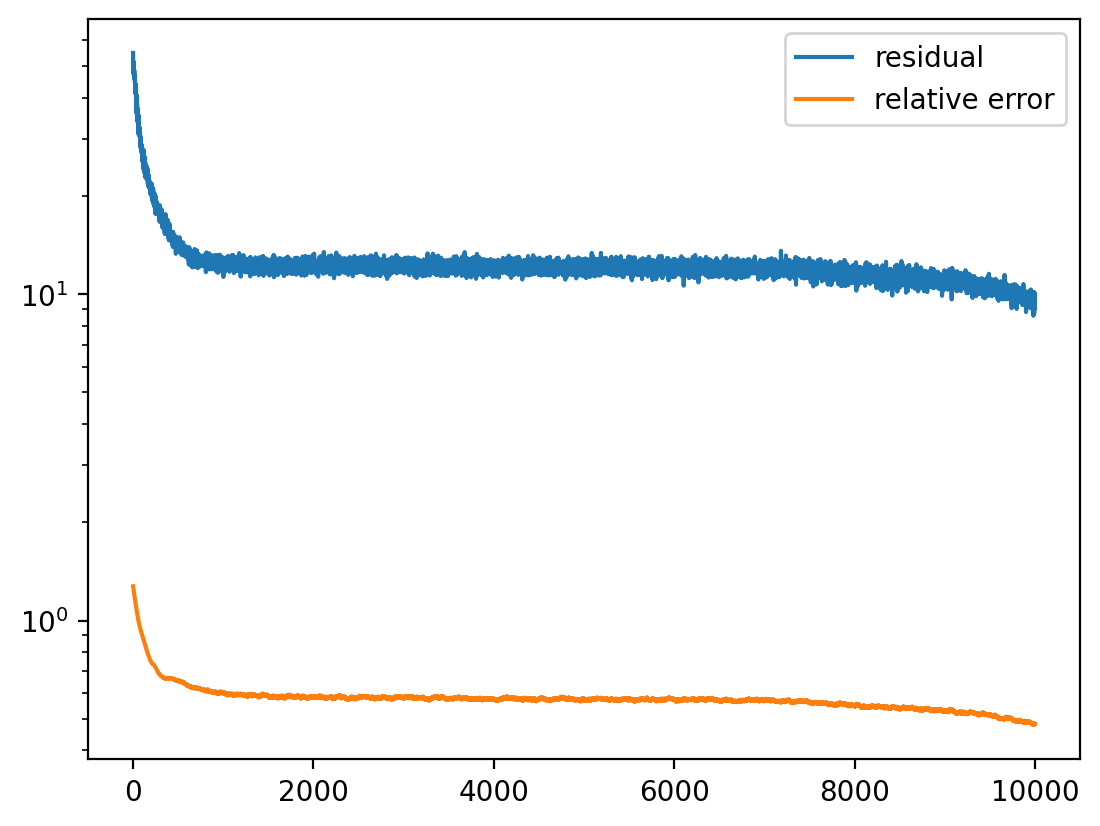

In [ ]:
plt.yscale("log")
plt.plot(history[:, 0], label="residual")
plt.plot(history[:, 1], label="relative error")
print(history[-1, 1])
plt.legend();

In [ ]:
approximate_solution = vmap(model, in_axes=(0, None))(coords_L, B)

a_s = jnp.zeros((coords_all.shape[0],))
a_s = a_s.at[kept_indices].set(approximate_solution)

exact_sol = jnp.zeros((coords_all.shape[0],))
exact_sol = exact_sol.at[kept_indices].set(sol)

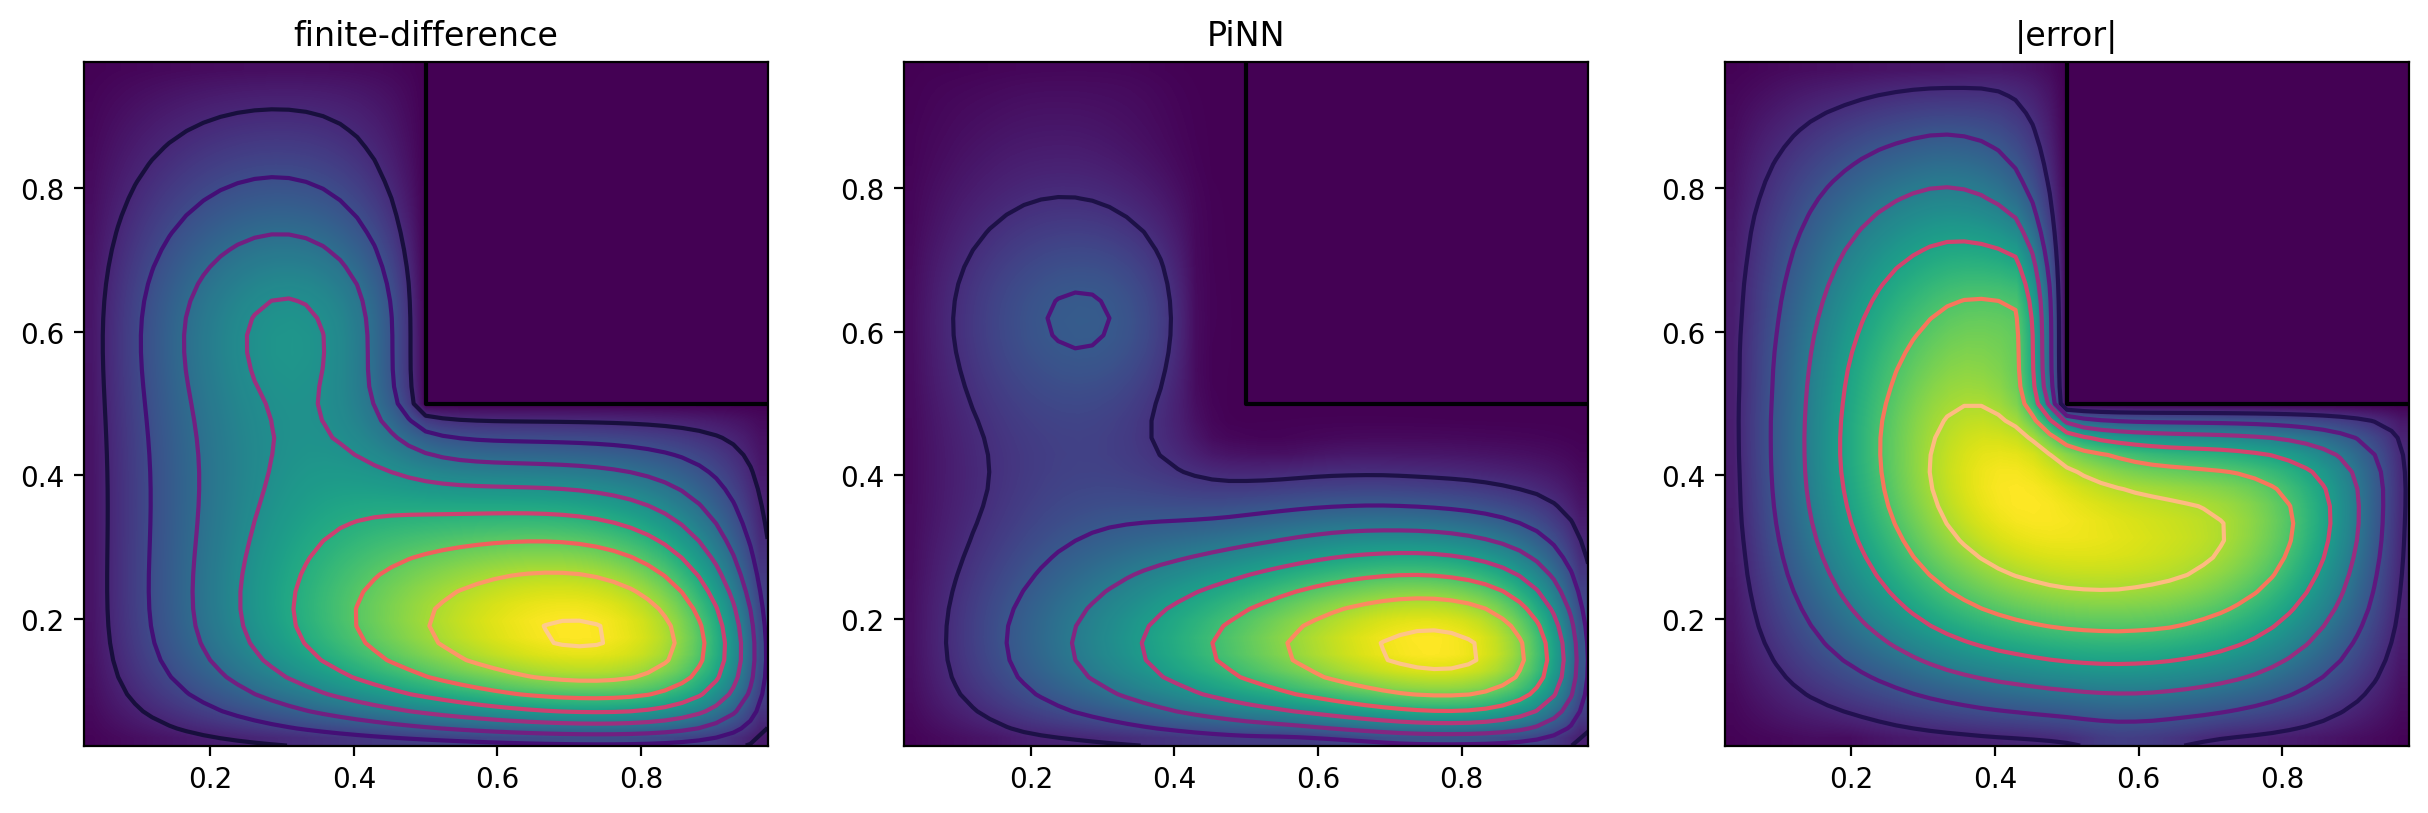

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
N = 2*n + 1
ax[0].imshow(exact_sol.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal")
ax[0].contour(coords_all[:, 0].reshape(N, N), coords_all[:, 1].reshape(N, N), exact_sol.reshape(N, N), cmap='magma', levels=8)
ax[0].set_title("finite-difference")

ax[1].imshow(a_s.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal")
ax[1].contour(coords_all[:, 0].reshape(N, N), coords_all[:, 1].reshape(N, N), a_s.reshape(N, N), cmap='magma', levels=8)
ax[1].set_title("PiNN")

e = jnp.abs(exact_sol - a_s)
ax[2].imshow(e.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal")
ax[2].contour(coords_all[:, 0].reshape(N, N), coords_all[:, 1].reshape(N, N), e.reshape(N, N), cmap='magma', levels=8)
ax[2].set_title("|error|");

# Residual loss (distance function)

## Distance function

Floater’s mean value coordinates:

1. https://www.sciencedirect.com/science/article/abs/pii/S0167839603000025
2. https://arxiv.org/abs/2104.08426

In [ ]:
@jit
def distance_function(x, R):
    r = (x - R)
    w = 0
    for i in range(6):
        ri, rip1 = jnp.linalg.norm(r[i]), jnp.linalg.norm(r[i+1])
        t = (r[i][0] * r[i+1][1] - r[i][1]*r[i+1][0]) / (ri*rip1 + jnp.sum(r[i]*r[i+1]))
        w = w + t * (1 / ri + 1 / rip1)
    w = 1 / w
    return w

In [ ]:
R = jnp.array([
    [0, 0],
    [1.0, 0],
    [1.0, 0.5],
    [0.5, 0.5],
    [0.5, 1.0],
    [0, 1.0],
    [0, 0]
])

id = lambda x: x[0]
n = 50
N = M = 2*n + 1
x = jnp.linspace(0, 1, N+2)[1:-1]
y = jnp.linspace(0, 1, M+2)[1:-1]
b2_vals, rhs, sol, coords_all, coords_L, boundary_points, kept_indices = get_solution_data(n, id, id)

phi = vmap(distance_function, in_axes=[0, None])(coords_L, R)

phi_extended = jnp.zeros((N*N))
phi_extended = phi_extended.at[kept_indices].set(phi)

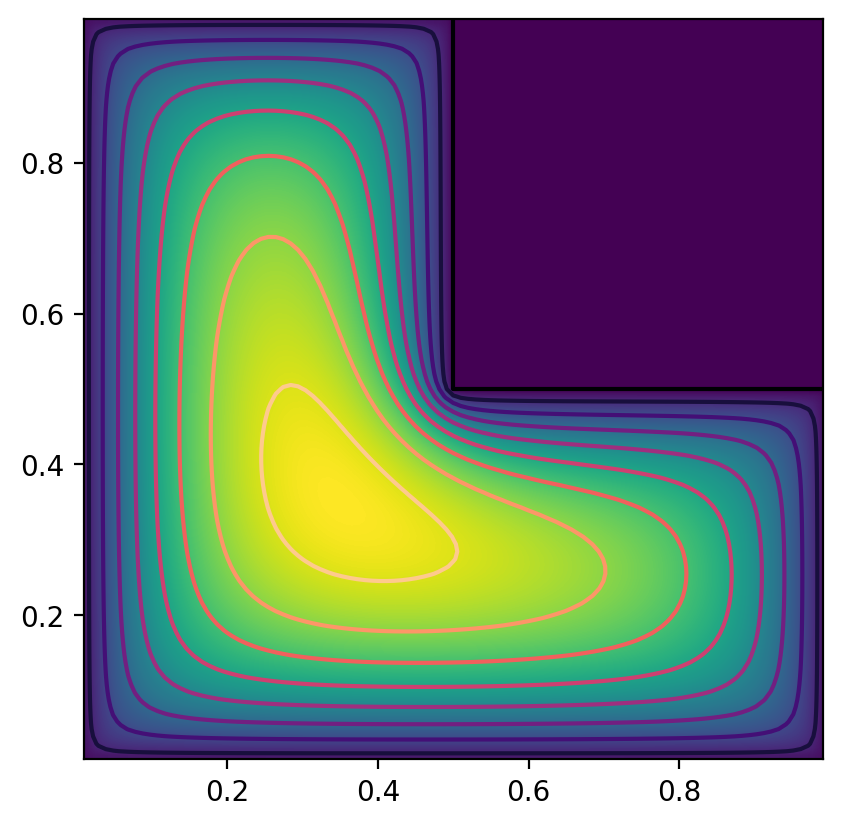

In [ ]:
plt.imshow(phi_extended.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal")
plt.contour(coords_all[:, 0].reshape(N, N), coords_all[:, 1].reshape(N, N), phi_extended.reshape(N, N), cmap='magma', levels=8);

## Training

In [ ]:
class PiNN(eqx.Module):
    matrices: list
    biases: list

    def __init__(self, N_features, N_layers, key):
        keys = random.split(key, N_layers+1)
        features = [N_features[0],] + [N_features[1],]*(N_layers-1) + [N_features[-1],]
        self.matrices = [random.normal(key, (f_in, f_out)) / jnp.sqrt((f_in + f_out)/2) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]
        keys = random.split(keys[-1], N_layers)
        self.biases = [random.normal(key, (f_out,)) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]

    def __call__(self, x, B):
        f = jnp.concatenate([jnp.cos(B @ x), jnp.sin(B @ x)], 0)
        f = f @ self.matrices[0] + self.biases[0]
        for i in range(1, len(self.matrices)):
            f = gelu(f)
            f = f @ self.matrices[i] + self.biases[i]
        output = f[0] * distance_function(x, R)
        return output

def compute_loss(model, coordinates, B, rhs, b):
    def l(x):
        flux_x = lambda x: grad(model, argnums=0)(x, B)[0]
        flux_y = lambda x: grad(model, argnums=0)(x, B)[1]
        return grad(flux_x)(x)[0] + grad(flux_y)(x)[1]
    u = vmap(model, in_axes=(0, None))(coordinates, B)
    return jnp.linalg.norm(-vmap(l)(coordinates) + b*u - rhs)

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step(model, coordinates, B, rhs, b, optim, opt_state):
    loss, grads = compute_loss_and_grads(model, coordinates, B, rhs, b)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
N_epochs = 10000
M_take = 32*32

b2 = lambda coords: jnp.cos(jnp.pi*coords[0] + 3*jnp.pi*coords[1])**2
f = lambda coords: jnp.exp(jnp.sin(4*jnp.pi*coords[1]))*coords[0]

n = 20
N = M = 2*n + 1
x = jnp.linspace(0, 1, N+2)[1:-1]
y = jnp.linspace(0, 1, M+2)[1:-1]
b2_vals, rhs, sol, coords_all, coords_L, boundary_points, kept_indices = get_solution_data(n, b2, f)

N_fourier_features = 25
key = random.PRNGKey(23)
B = random.normal(key, (N_fourier_features, 2))*10
ind = jnp.arange(coords_L.shape[0])

N_features = [2*N_fourier_features, 50, 1]
N_layers = 3
key = random.PRNGKey(14)
model = PiNN(N_features, N_layers, key)

learning_rate = 1e-4
N_drop = 20000
gamma = 0.5
sc = optax.exponential_decay(learning_rate, N_drop, gamma)
optim = optax.lion(learning_rate=sc)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

carry = [model, opt_state, sol, coords_L, B, b2_vals, rhs, sol, ind]
keys = random.split(key, N_epochs)

In [ ]:
def make_step_scan(carry, key):
    model, opt_state, sol, coords, B, b2_vals, rhs, sol, ind = carry
    n = random.choice(key, ind, shape = (M_take,))
    loss, model, opt_state = make_step(model, coords[n], B, rhs[n], b2_vals[n], optim, opt_state)
    approximate_solution = vmap(model, in_axes=(0, None))(coords, B)
    error = jnp.linalg.norm(sol - approximate_solution) / jnp.linalg.norm(sol)
    return [model, opt_state, sol, coords, B, b2_vals, rhs, sol, ind], jnp.stack([loss, error])

In [ ]:
start = time.time()
data, history = scan(make_step_scan, carry, keys)
model = data[0]
stop = time.time()
print((stop - start)/60)

0.6406821767489116


0.0048471936


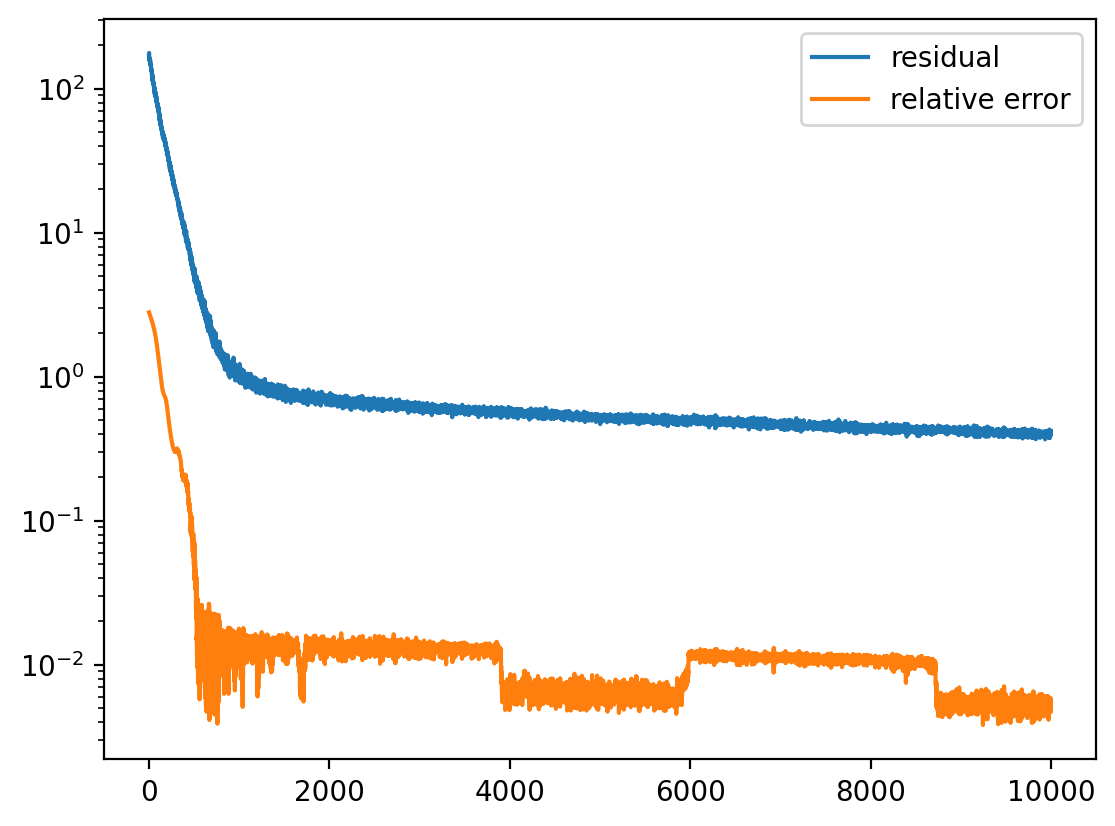

In [ ]:
plt.yscale("log")
plt.plot(history[:, 0], label="residual")
plt.plot(history[:, 1], label="relative error")
print(history[-1, 1])
plt.legend();

In [ ]:
approximate_solution = vmap(model, in_axes=(0, None))(coords_L, B)

a_s = jnp.zeros((coords_all.shape[0],))
a_s = a_s.at[kept_indices].set(approximate_solution)

exact_sol = jnp.zeros((coords_all.shape[0],))
exact_sol = exact_sol.at[kept_indices].set(sol)

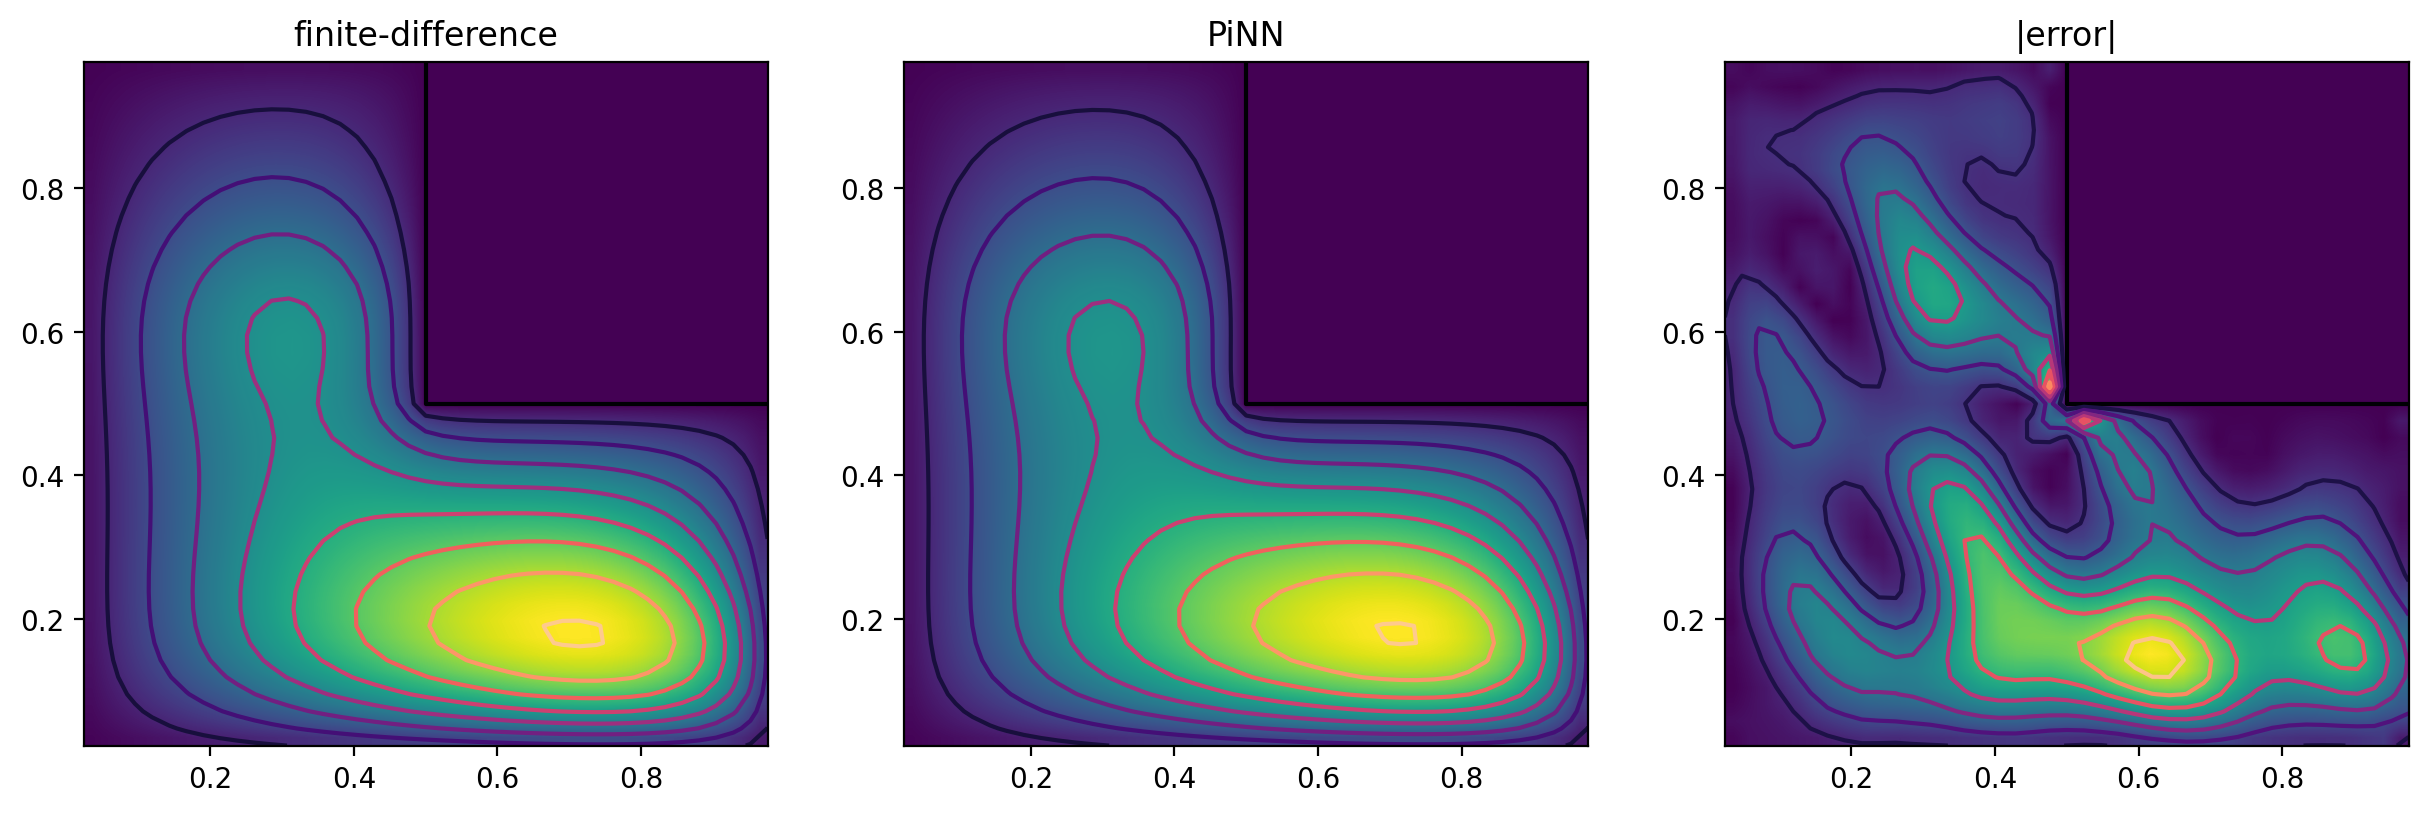

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
N = 2*n + 1
ax[0].imshow(exact_sol.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal")
ax[0].contour(coords_all[:, 0].reshape(N, N), coords_all[:, 1].reshape(N, N), exact_sol.reshape(N, N), cmap='magma', levels=8)
ax[0].set_title("finite-difference")

ax[1].imshow(a_s.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal")
ax[1].contour(coords_all[:, 0].reshape(N, N), coords_all[:, 1].reshape(N, N), a_s.reshape(N, N), cmap='magma', levels=8)
ax[1].set_title("PiNN")

e = jnp.abs(exact_sol - a_s)
ax[2].imshow(e.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal")
ax[2].contour(coords_all[:, 0].reshape(N, N), coords_all[:, 1].reshape(N, N), e.reshape(N, N), cmap='magma', levels=8)
ax[2].set_title("|error|");

# Residual loss (boundary)

In [ ]:
class PiNN(eqx.Module):
    matrices: list
    biases: list

    def __init__(self, N_features, N_layers, key):
        keys = random.split(key, N_layers+1)
        features = [N_features[0],] + [N_features[1],]*(N_layers-1) + [N_features[-1],]
        self.matrices = [random.normal(key, (f_in, f_out)) / jnp.sqrt((f_in + f_out)/2) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]
        keys = random.split(keys[-1], N_layers)
        self.biases = [random.normal(key, (f_out,)) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]

    def __call__(self, x, B):
        f = jnp.concatenate([jnp.cos(B @ x), jnp.sin(B @ x)], 0)
        f = f @ self.matrices[0] + self.biases[0]
        for i in range(1, len(self.matrices)):
            f = gelu(f)
            f = f @ self.matrices[i] + self.biases[i]
        return f[0]

def compute_loss(model, coordinates_list, B, rhs, b, weights):
    coordinates, boundary_points = coordinates_list
    def l(x):
        flux_x = lambda x: grad(model, argnums=0)(x, B)[0]
        flux_y = lambda x: grad(model, argnums=0)(x, B)[1]
        return grad(flux_x)(x)[0] + grad(flux_y)(x)[1]
    u = vmap(model, in_axes=(0, None))(coordinates, B)
    l1 = jnp.linalg.norm(-vmap(l)(coordinates) + b*u - rhs)
    l2 = jnp.linalg.norm(vmap(model, in_axes=[0, None])(boundary_points, B))
    return l1*weights[0] + l2*weights[1]


compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step(model, coordinates, B, rhs, b, weights, optim, opt_state):
    loss, grads = compute_loss_and_grads(model, coordinates, B, rhs, b, weights)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
N_epochs = 30000
M_take = 32*32
B_take = 100
weights = jnp.array([1, 10])

b2 = lambda coords: jnp.cos(jnp.pi*coords[0] + 3*jnp.pi*coords[1])**2
f = lambda coords: jnp.exp(jnp.sin(4*jnp.pi*coords[1]))*coords[0]

n = 20
N = M = 2*n + 1
x = jnp.linspace(0, 1, N+2)[1:-1]
y = jnp.linspace(0, 1, M+2)[1:-1]
b2_vals, rhs, sol, coords_all, coords_L, boundary_points, kept_indices = get_solution_data(n, b2, f)

N_fourier_features = 25
key = random.PRNGKey(23)
B = random.normal(key, (N_fourier_features, 2))*10
ind = jnp.arange(coords_L.shape[0])
boundary_ind = jnp.arange(boundary_points.shape[0])

N_features = [2*N_fourier_features, 50, 1]
N_layers = 3
key = random.PRNGKey(14)
model = PiNN(N_features, N_layers, key)

learning_rate = 1e-4
N_drop = 10000
gamma = 0.5
sc = optax.exponential_decay(learning_rate, N_drop, gamma)
optim = optax.lion(learning_rate=sc)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

carry = [model, opt_state, sol, [coords_L, boundary_points], B, b2_vals, rhs, sol, ind, boundary_ind, weights]
keys = random.split(key, N_epochs)

In [ ]:
def make_step_scan(carry, key):
    model, opt_state, sol, coords, B, b2_vals, rhs, sol, ind, boundary_ind, weights = carry
    n = random.choice(key, ind, shape = (M_take,))
    m = random.choice(key, boundary_ind, shape = (B_take,))
    loss, model, opt_state = make_step(model, [coords[0][n], coords[1][m]], B, rhs[n], b2_vals[n], weights, optim, opt_state)
    approximate_solution = vmap(model, in_axes=(0, None))(coords[0], B)
    error = jnp.linalg.norm(sol - approximate_solution) / jnp.linalg.norm(sol)
    return [model, opt_state, sol, coords, B, b2_vals, rhs, sol, ind, boundary_ind, weights], jnp.stack([loss, error])

In [ ]:
start = time.time()
data, history = scan(make_step_scan, carry, keys)
model = data[0]
stop = time.time()
print((stop - start)/60)

0.6293750882148743


0.0178782


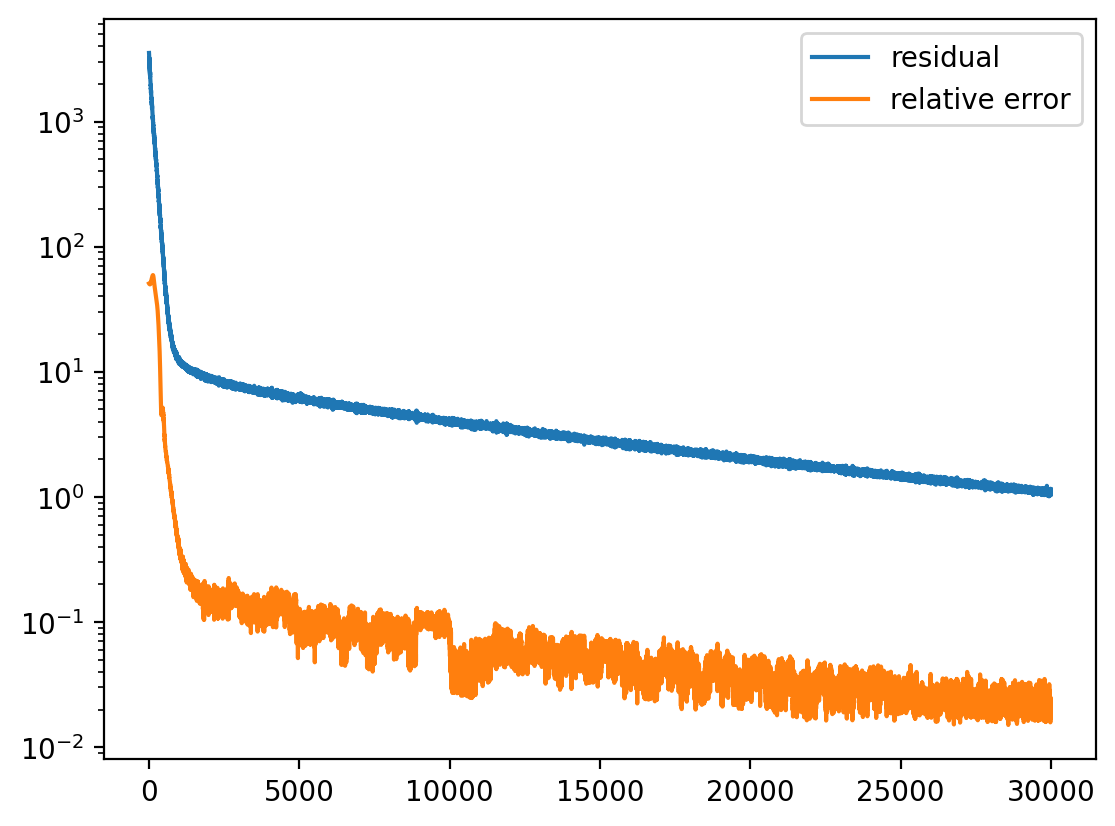

In [ ]:
plt.yscale("log")
plt.plot(history[:, 0], label="residual")
plt.plot(history[:, 1], label="relative error")
print(history[-1, 1])
plt.legend();

In [ ]:
approximate_solution = vmap(model, in_axes=(0, None))(coords_L, B)

a_s = jnp.zeros((coords_all.shape[0],))
a_s = a_s.at[kept_indices].set(approximate_solution)

exact_sol = jnp.zeros((coords_all.shape[0],))
exact_sol = exact_sol.at[kept_indices].set(sol)

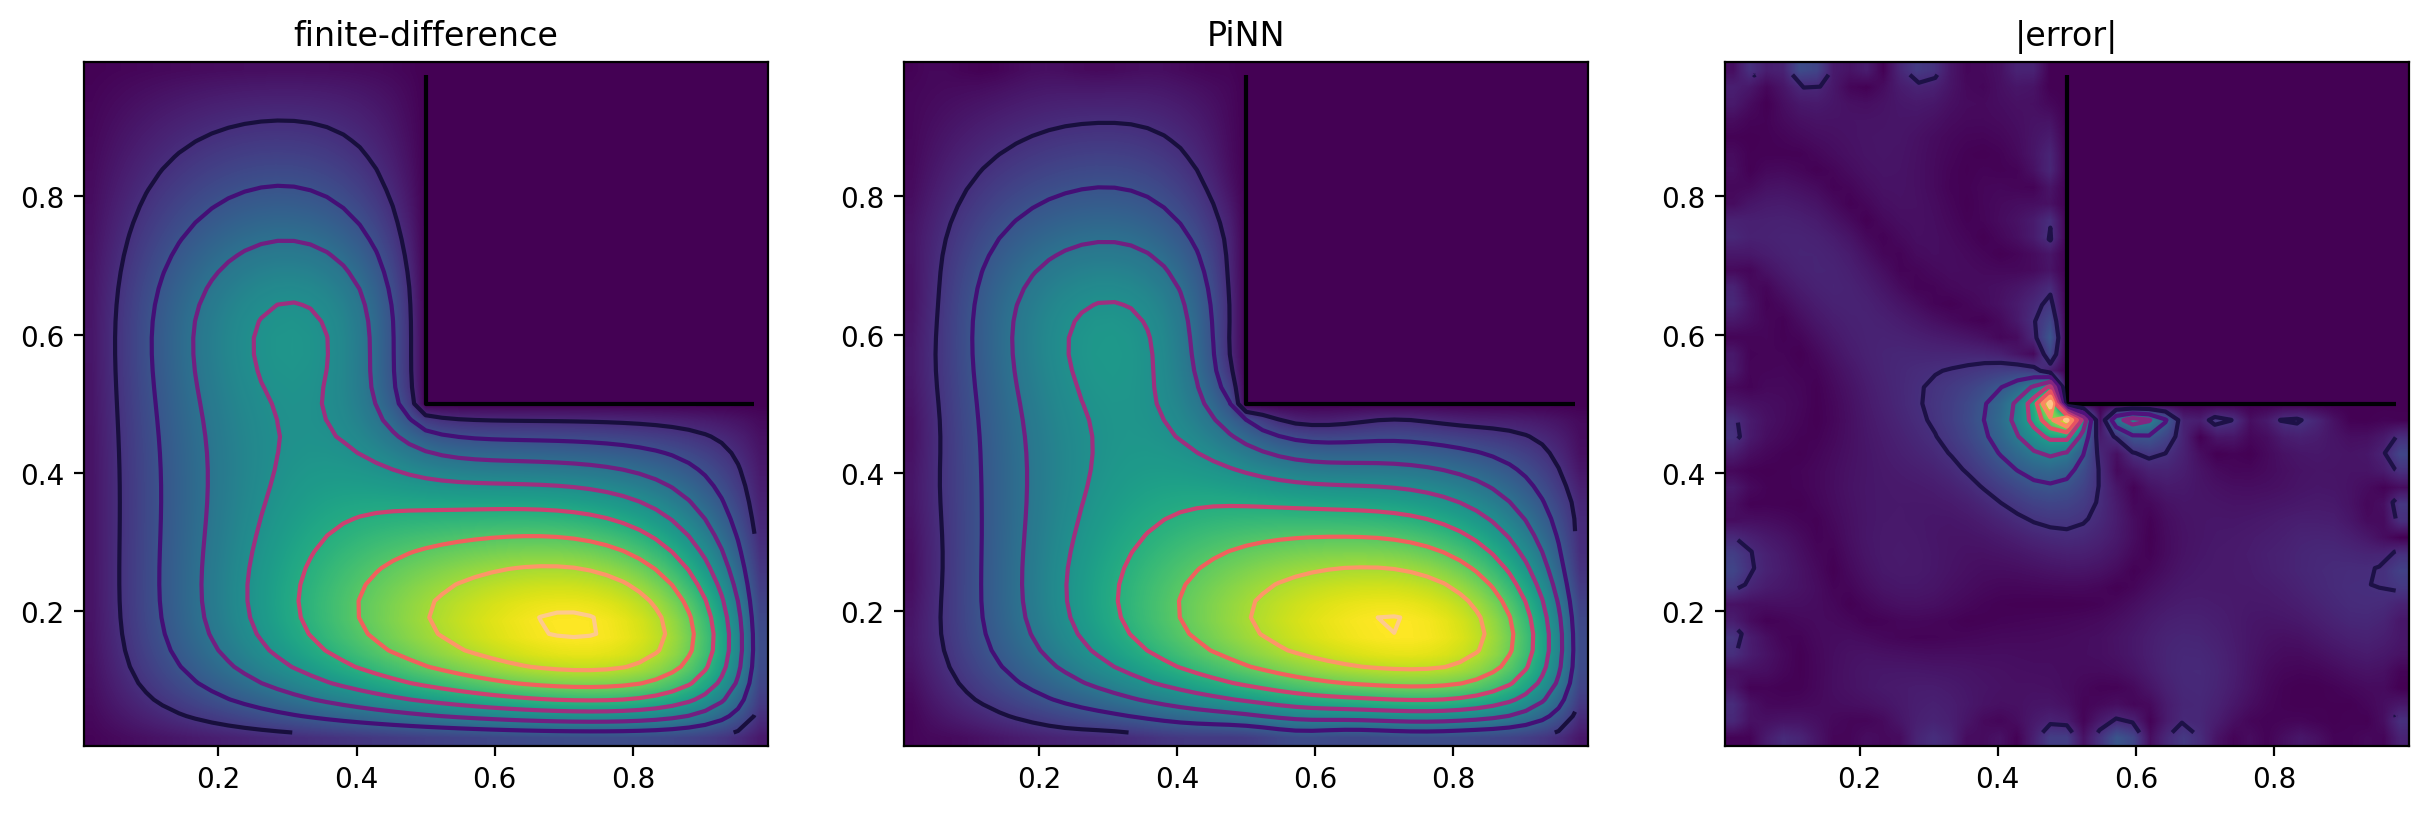

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
N = 2*n + 1
ax[0].imshow(exact_sol.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal")
ax[0].contour(coords_all[:, 0].reshape(N, N), coords_all[:, 1].reshape(N, N), exact_sol.reshape(N, N), cmap='magma', levels=8)
ax[0].set_title("finite-difference")

ax[1].imshow(a_s.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal")
ax[1].contour(coords_all[:, 0].reshape(N, N), coords_all[:, 1].reshape(N, N), a_s.reshape(N, N), cmap='magma', levels=8)
ax[1].set_title("PiNN")

e = jnp.abs(exact_sol - a_s)
ax[2].imshow(e.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal")
ax[2].contour(coords_all[:, 0].reshape(N, N), coords_all[:, 1].reshape(N, N), e.reshape(N, N), cmap='magma', levels=8)
ax[2].set_title("|error|");

# Astral loss (distance function)

In [ ]:
@jit
def distance_function(x, R):
    r = (x - R)
    w = 0
    for i in range(6):
        ri, rip1 = jnp.linalg.norm(r[i]), jnp.linalg.norm(r[i+1])
        t = (r[i][0] * r[i+1][1] - r[i][1]*r[i+1][0]) / (ri*rip1 + jnp.sum(r[i]*r[i+1]))
        w = w + t * (1 / ri + 1 / rip1)
    w = 1 / w
    return w

R = jnp.array([
    [0, 0],
    [1.0, 0],
    [1.0, 0.5],
    [0.5, 0.5],
    [0.5, 1.0],
    [0, 1.0],
    [0, 0]
])

In [ ]:
class PiNN(eqx.Module):
    matrices: list
    biases: list

    def __init__(self, N_features, N_layers, key):
        keys = random.split(key, N_layers+1)
        features = [N_features[0],] + [N_features[1],]*(N_layers-1) + [N_features[-1],]
        self.matrices = [random.normal(key, (f_in, f_out)) / jnp.sqrt((f_in + f_out)/2) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]
        keys = random.split(keys[-1], N_layers)
        self.biases = [random.normal(key, (f_out,)) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]

    def __call__(self, x, B):
        f = jnp.concatenate([jnp.cos(B @ x), jnp.sin(B @ x)], 0)
        f = f @ self.matrices[0] + self.biases[0]
        for i in range(1, len(self.matrices)):
            f = gelu(f)
            f = f @ self.matrices[i] + self.biases[i]
        output = f[0] * distance_function(x, R)
        return output

class PiNNu(eqx.Module):
    matrices: list
    biases: list

    def __init__(self, N_features, N_layers, key):
        keys = random.split(key, N_layers+1)
        features = [N_features[0],] + [N_features[1],]*(N_layers-1) + [N_features[-1],]
        self.matrices = [random.normal(key, (f_in, f_out)) / jnp.sqrt((f_in + f_out)/2) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]
        keys = random.split(keys[-1], N_layers)
        self.biases = [random.normal(key, (f_out,)) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]

    def __call__(self, x, B):
        f = jnp.concatenate([jnp.cos(B @ x), jnp.sin(B @ x)], 0)
        f = f @ self.matrices[0] + self.biases[0]
        for i in range(1, len(self.matrices)):
            f = gelu(f)
            f = f @ self.matrices[i] + self.biases[i]
        return f[0]

class PiNN3(eqx.Module):
    models: list
    beta: jnp.array

    def __init__(self, N_features, N_layers, key):
        keys = random.split(key, 3)
        self.models = [PiNNu(N_features, N_layers, key) for key in keys[:2]]
        self.models.append(PiNN(N_features, N_layers, keys[-1]))
        self.beta = jnp.array([1.0,])

    def __call__(self, x, B, i):
        return self.models[i](x, B)

def compute_loss_(model, coordinates, weights, RHS, b, B):
    C_F = 1 / (2*jnp.pi)
    flux = vmap(grad(lambda x, B: model(x, B, 2), argnums=0), in_axes=(0, None))(coordinates, B)
    dx_y = [vmap(grad(lambda x, B: model(x, B, i), argnums=0), in_axes=(0, None))(coordinates, B)[:, i] for i in [0, 1]]
    y1 = vmap(model, in_axes=(0, None, None))(coordinates, B, 0)
    y2 = vmap(model, in_axes=(0, None, None))(coordinates, B, 1)
    u = vmap(model, in_axes=(0, None, None))(coordinates, B, 2)
    integrand = (1 + model.beta[0]**2)*(C_F**2*(RHS - b*u + dx_y[0] + dx_y[1])**2 / (C_F**2*b*(1 + model.beta[0]**2) + 1) +  ((flux[:, 0] - y1)**2 + (flux[:, 1] - y2)**2) / (model.beta[0]**2))
    l = jnp.sum(jnp.sum(integrand.reshape(weights.size, weights.size)*weights, axis=1) * weights[0])
    return l

def compute_loss(model, coordinates, weights, RHS, b, B):
    l = 0
    for c, w, r, b_ in zip(coordinates, weights, RHS, b):
        l = l + compute_loss_(model, c, w, r, b_, B)
    return l

def compute_error_energy_norm_(model, coordinates, weights, b, dx_sol, dy_sol, sol, B):
    flux = vmap(lambda x: grad(model, argnums=0)(x, B, 2))(coordinates)
    u = vmap(model, in_axes=(0, None, None))(coordinates, B, 2)
    integrand = (flux[:, 0] - dx_sol)**2 + (flux[:, 1] - dy_sol)**2 + b * (u - sol)**2
    l = jnp.sum(jnp.sum(integrand.reshape(weights.size, weights.size)*weights, axis=1) * weights[0])
    return l

@eqx.filter_jit
def compute_error_energy_norm(model, coordinates, weights, b, dx_sol, dy_sol, sol, B):
    e = 0
    for c, w, b_, dx_, dy_, s in zip(coordinates, weights, b, dx_sol, dy_sol, sol):
        e = e + compute_error_energy_norm_(model, c, w, b_, dx_, dy_, s, B)
    return e

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step(model, coordinates, weights, RHS, b, B, optim, opt_state):
    loss, grads = compute_loss_and_grads(model, coordinates, weights, RHS, b, B)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
N_mesh = 20
x, weights = roots_legendre(N_mesh)
x = jnp.array((x + 1)/4)
weights1 = jnp.array(weights).reshape(1, -1) / 4
coords1 = jnp.stack(jnp.meshgrid(x, x, indexing="ij"), 2)
coords1 = coords1.reshape(-1, 2)

weights2 = jnp.array(weights).reshape(1, -1) / 4
coords2 = jnp.stack(jnp.meshgrid(x + 0.5, x, indexing="ij"), 2)
coords2 = coords2.reshape(-1, 2)

weights3 = jnp.array(weights).reshape(1, -1) / 4
coords3 = jnp.stack(jnp.meshgrid(x, x + 0.5, indexing="ij"), 2)
coords3 = coords3.reshape(-1, 2)

coordinates = [coords1, coords2, coords3]
weights = [weights1, weights2, weights3]

b2 = lambda coords: jnp.cos(jnp.pi*coords[0] + 3*jnp.pi*coords[1])**2
f = lambda coords: jnp.exp(jnp.sin(4*jnp.pi*coords[1]))*coords[0]

n = 100
b2_vals, rhs, sol, coords_all, coords_L, boundary_points, kept_indices = get_solution_data(n, b2, f)

a_s = np.zeros((coords_all.shape[0],))
a_s[kept_indices] = np.array(sol)
a_s = a_s.reshape([2*n+1, 2*n+1])

x = y = jnp.linspace(0, 1, 2*n+3)
coordinates_ = np.stack(np.meshgrid(x, y, indexing="ij"), 2)
approximate_solution = np.zeros(coordinates_.shape[:2])
approximate_solution[1:-1, 1:-1] = a_s

dy = findiff.FinDiff(1, y[1] - y[0], 1, acc=2)
dx = findiff.FinDiff(0, x[1] - x[0], 1, acc=2)

ds_dx = dx(approximate_solution)
ds_dy = dy(approximate_solution)

ds_dx = [jnp.array(griddata(coordinates_.reshape(-1, 2), ds_dx.reshape(-1,), c)) for c in coordinates]
ds_dy = [jnp.array(griddata(coordinates_.reshape(-1, 2), ds_dy.reshape(-1,), c)) for c in coordinates]
s = [jnp.array(griddata(coordinates_.reshape(-1, 2), approximate_solution.reshape(-1,), c)) for c in coordinates]

n_test = 20
b2_vals, rhs, sol_uniform, coords_all, coords_L, boundary_points, kept_indices = get_solution_data(n, b2, f)

N_fourier_features = 25
key = random.PRNGKey(23)
B = random.normal(key, (N_fourier_features, 2))*10

N_features = [2*N_fourier_features, 50, 1]
N_layers = 3
key = random.PRNGKey(14)
model = PiNN3(N_features, N_layers, key)

learning_rate = 1e-4
N_epochs = 10000
N_drop = 10000
gamma = 0.5
sc = optax.exponential_decay(learning_rate, N_drop, gamma)
optim = optax.lion(learning_rate=sc)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

RHS = [f(coords.T) for coords in coordinates]
b2_vals = [b2(coords.T) for coords in coordinates]

carry = [model, opt_state, coordinates, weights, RHS, b2_vals, B, sol_uniform, coords_L, ds_dx, ds_dy, s]
keys = random.split(key, N_epochs)

In [ ]:
def make_step_scan(carry, key):
    model, opt_state, coordinates, weights, RHS, b, B, sol_uniform, coords_L, ds_dx, ds_dy, s = carry
    loss, model, opt_state = make_step(model, coordinates, weights, RHS, b, B, optim, opt_state)
    approximate_solution = vmap(model, in_axes=(0, None, None))(coords_L, B, 2)
    error = jnp.linalg.norm(approximate_solution - sol_uniform) / jnp.linalg.norm(sol_uniform)
    error_ = compute_error_energy_norm(model, coordinates, weights, b, ds_dx, ds_dy, s, B)
    return [model, opt_state, coordinates, weights, RHS, b, B, sol_uniform, coords_L, ds_dx, ds_dy, s], jnp.stack([jnp.sqrt(loss), error, error_])

In [ ]:
start = time.time()
data, history = scan(make_step_scan, carry, keys)
model = data[0]
stop = time.time()
print((stop - start)/60)

1.3752281149228414


0.002648818


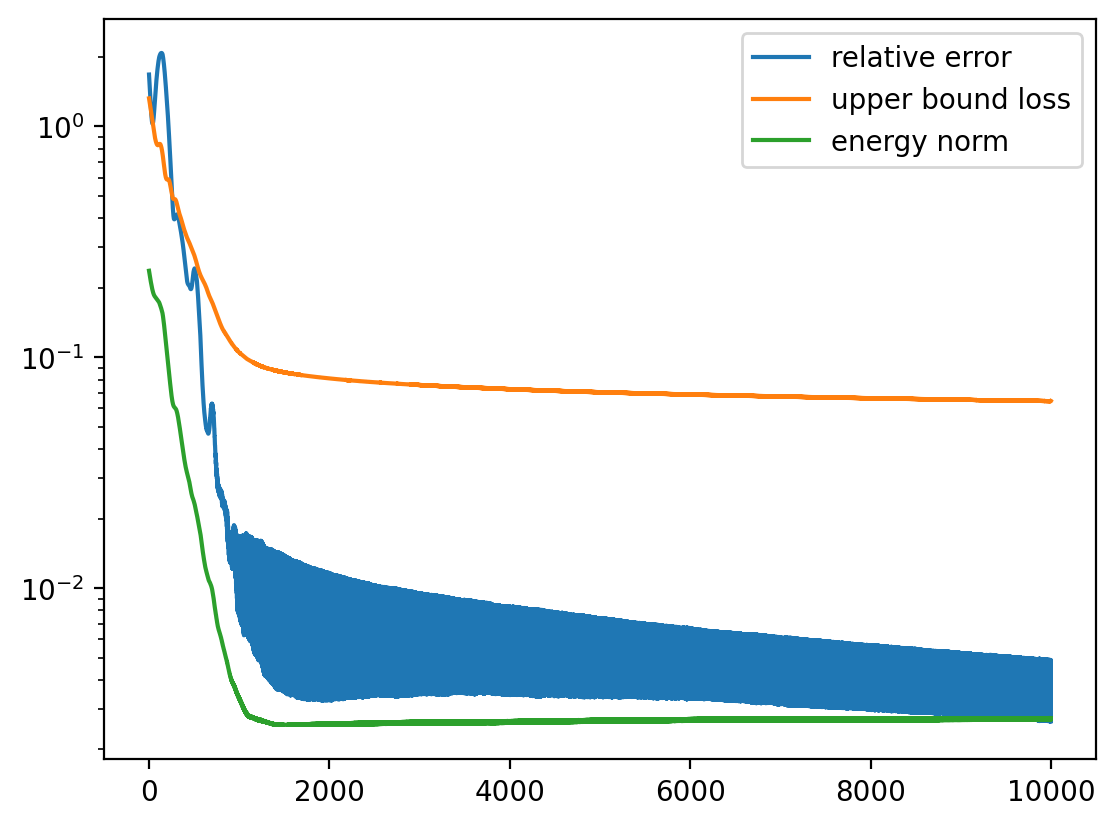

In [ ]:
plt.yscale("log")
plt.plot(history[:, 1], label="relative error")
plt.plot(jnp.sqrt(history[:, 0]), label="upper bound loss")
plt.plot(jnp.sqrt(history[:, 2]), label="energy norm")
print(history[-1, 1])
plt.legend();

In [ ]:
approximate_solution = vmap(model, in_axes=(0, None, None))(coords_L, B, 2)

a_s = jnp.zeros((coords_all.shape[0],))
a_s = a_s.at[kept_indices].set(approximate_solution)

exact_sol = jnp.zeros((coords_all.shape[0],))
exact_sol = exact_sol.at[kept_indices].set(sol)

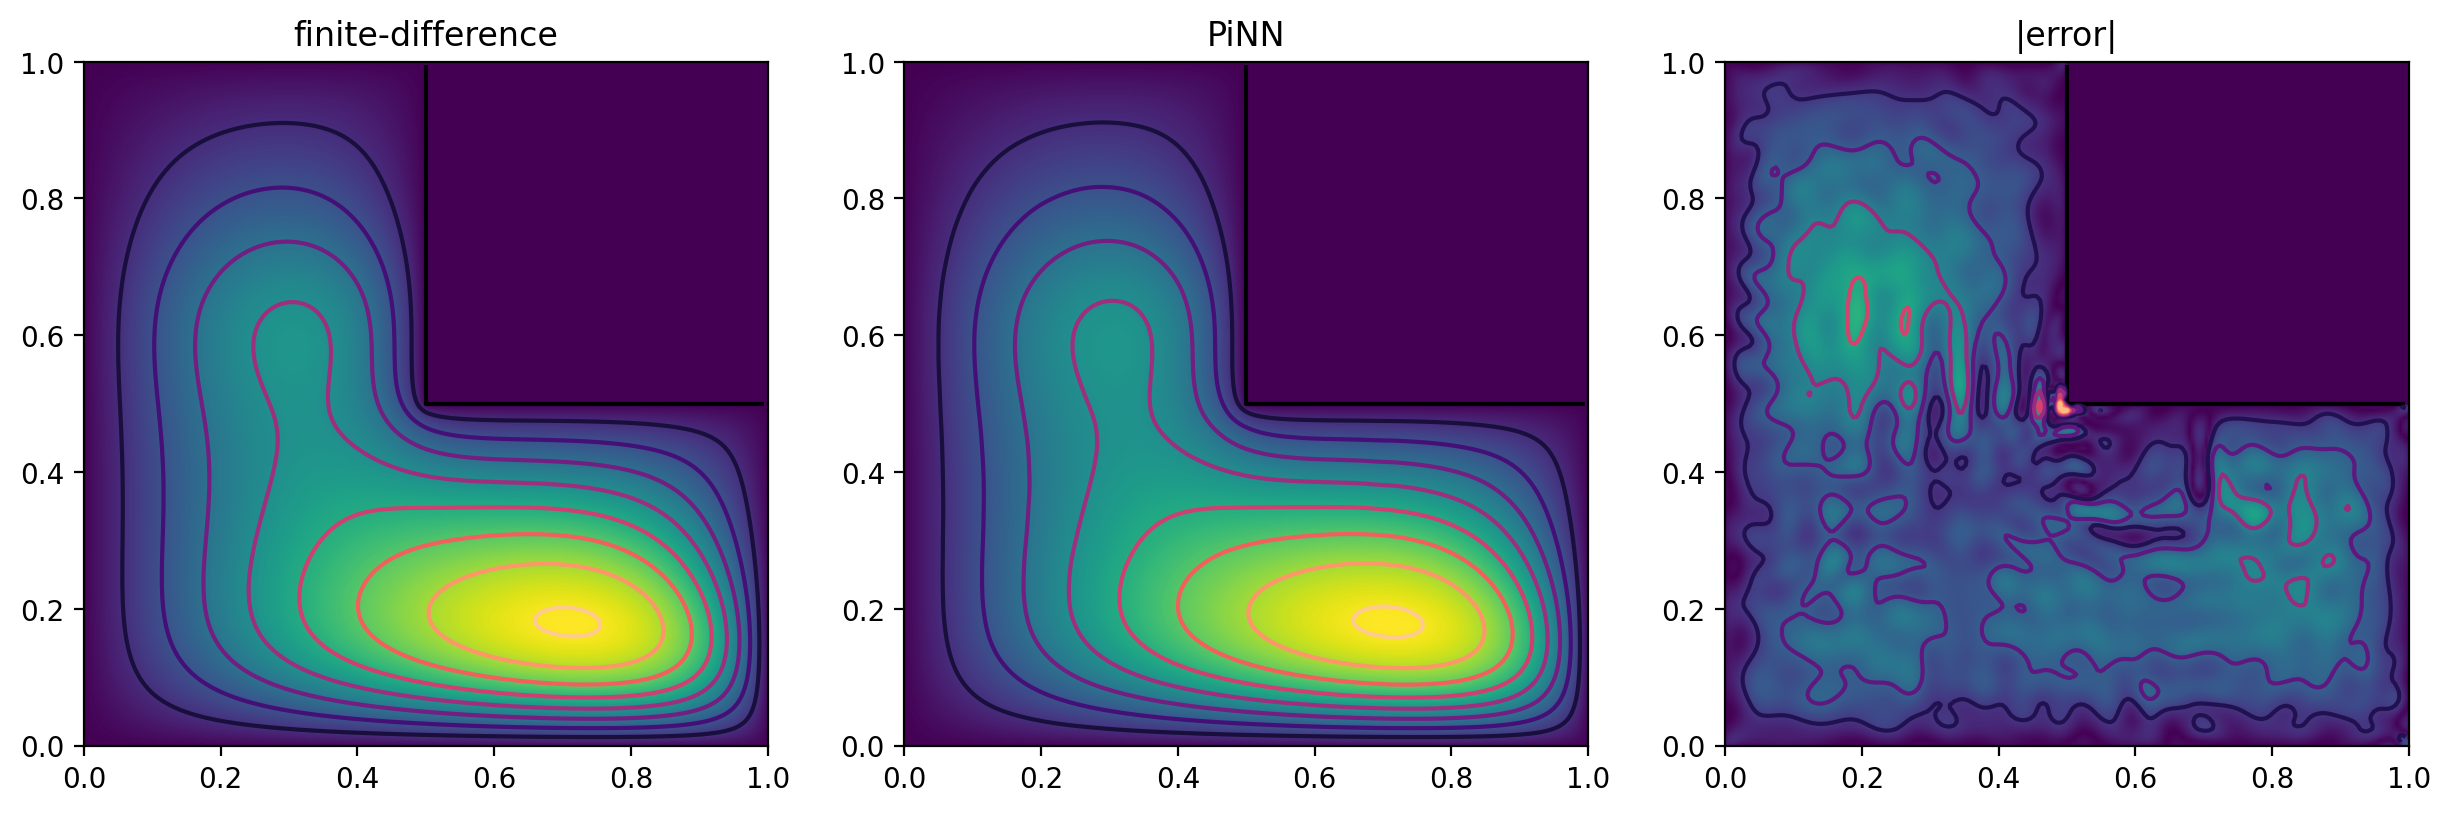

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
N = 2*n + 1
ax[0].imshow(exact_sol.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal")
ax[0].contour(coords_all[:, 0].reshape(N, N), coords_all[:, 1].reshape(N, N), exact_sol.reshape(N, N), cmap='magma', levels=8)
ax[0].set_title("finite-difference")

ax[1].imshow(a_s.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal")
ax[1].contour(coords_all[:, 0].reshape(N, N), coords_all[:, 1].reshape(N, N), a_s.reshape(N, N), cmap='magma', levels=8)
ax[1].set_title("PiNN")

e = jnp.abs(exact_sol - a_s)
ax[2].imshow(e.reshape(N, N).T, origin="lower", extent=[x[0], x[-1], y[0], y[-1]], interpolation='bilinear', aspect="equal")
ax[2].contour(coords_all[:, 0].reshape(N, N), coords_all[:, 1].reshape(N, N), e.reshape(N, N), cmap='magma', levels=8)
ax[2].set_title("|error|");